
image 1/1 c:\Users\User\Desktop\projeto-visao-computacional-2025.1\AC\AC6\images\cozinha.jpg: 640x640 2 bottles, 1 cup, 1 potted plant, 2 microwaves, 2 ovens, 44.8ms
Speed: 2.9ms preprocess, 44.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


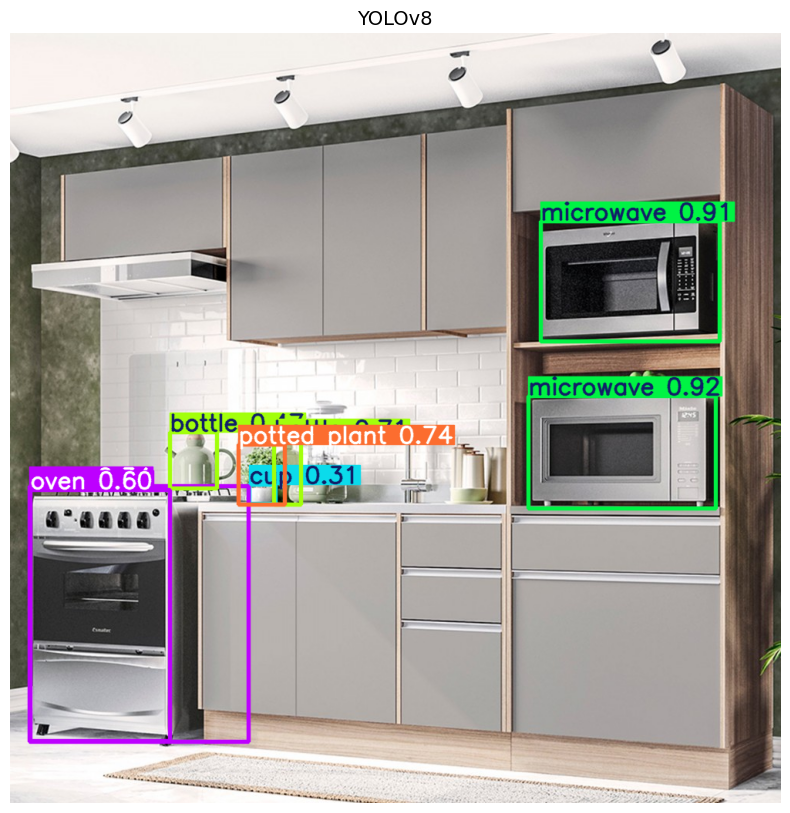

In [5]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Caminho da imagem
imagePath = "images/cozinha.jpg"

# Carregar modelo YOLOv8
model = YOLO("resources/yolov8n.pt") 

# Rodar detecção
results = model(imagePath)

# Renderizar caixas diretamente na imagem
rendered = results[0].plot()

# Mostrar imagem com matplotlib
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(rendered, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("YOLOv8")
plt.show()
